In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
import pandas as pd
from pathlib import Path
from disk_models import BasicEccentricDisk
from capture_simulation import CaptureSimulation
from hammy import Delta_eq, ResHam
import pickle
plt.rcParams['font.size'] = 16

In [2]:
Z_obs = pd.read_fwf('data/hl17_planets.dat', names=['System', 'Planet 1', 'Planet 2', 'MMR', 'Delta', 'Zd', 'E_Zd', 'e_Zd', 'Zp-d', 'E_Zp-d', 'e_Zp-d', 'Zh', 'E_Zh', 'e_Zh', 'Zp-h', 'E_Zp-h', 'e_Zp-h'])

In [21]:
path = Path('/mnt/data-big/mgoldberg/resonant-capture-simulation/results/stoch_disk/3_1_adiabatic_100.0/')
list(path.glob('*.csv'))

[PosixPath('/mnt/data-big/mgoldberg/resonant-capture-simulation/results/stoch_disk/3_1_adiabatic_100.0/results.csv')]

In [22]:
df = pd.read_csv(path / 'results.csv', index_col=0)
if 'kappa' in df.columns:
    sim_type = 'stoch_disk'
elif len(np.unique(df['fixed_tau_a']/df['fixed_tau_e'])) != 1:
    sim_type = 'disk'
elif 'pl_disk_mass' in df.columns:
    sim_type = 'planetesimals'
elif np.any(np.isfinite(df['tidal_tau_e'])):
    sim_type = 'tides'
else:
    raise
df = df[np.abs(df['Delta']) < 0.1]
print(len(df))
print(df.columns)
df.iloc[0]

95
Index(['p', 'q', 'm1', 'm2', 'a1_init', 'Delta_init', 'disk_end', 't_end',
       't_start_removal', 'fixed_tau_a', 'fixed_tau_e', 'kappa', 'Delta', 'e1',
       'e2', 'theta_hat', 'phi1_librating', 'phi2_librating',
       'theta_hat_librating', 'Delta_pomega', 'Zabs'],
      dtype='object')


p                             3
q                             1
m1                      0.00003
m2                      0.00003
a1_init                     0.1
Delta_init                  0.1
disk_end                40000.0
t_end                   50000.0
t_start_removal            0.75
fixed_tau_a           -300000.0
fixed_tau_e             -3000.0
kappa                       0.0
Delta                  0.000671
e1                     0.021505
e2                     0.023283
theta_hat              3.008678
phi1_librating             True
phi2_librating             True
theta_hat_librating        True
Delta_pomega           3.130804
Zabs                   0.031637
Name: 0, dtype: object

Text(0, 0.5, '$|\\mathcal{Z}|$')

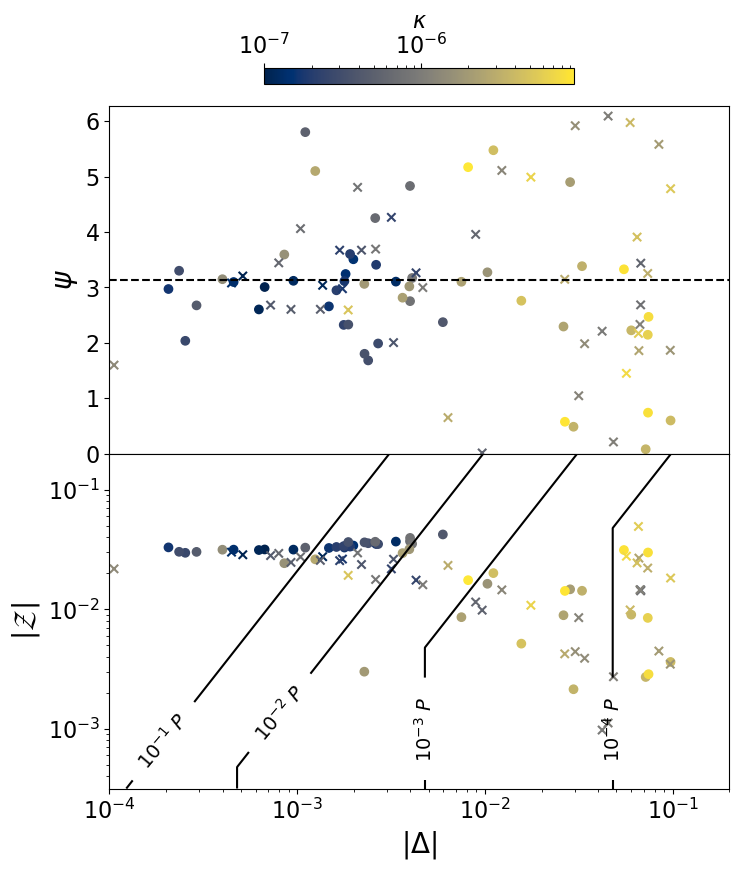

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(8,10), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1.3, 1]})

if sim_type == 'stoch_disk':
    for sub_frame, marker in zip([df.query('Delta > 0'), df.query('Delta < 0')], ['o', 'x']):
        axs[0].scatter(np.abs(sub_frame['Delta']), sub_frame['theta_hat'], c=sub_frame['kappa'], 
                   norm=LogNorm(df['kappa'].min(), df['kappa'].max()), cmap='cividis', marker=marker)
        axs[1].scatter(np.abs(sub_frame['Delta']), sub_frame['Zabs'], c=sub_frame['kappa'],
                   norm=LogNorm(df['kappa'].min(), df['kappa'].max()), cmap='cividis', marker=marker)
    fig.colorbar(axs[0].collections[0], ax=axs[0], label=r'$\kappa$', shrink=0.5, location='top')
elif sim_type == 'disk':
    for sub_frame, marker in zip([df.query('Delta > 0'), df.query('Delta < 0')], ['o', 'x']):
        axs[0].scatter(np.abs(sub_frame['Delta']), sub_frame['theta_hat'], c=sub_frame['fixed_tau_a']/sub_frame['fixed_tau_e'], 
                   norm=LogNorm((df['fixed_tau_a']/df['fixed_tau_e']).min(), (df['fixed_tau_a']/df['fixed_tau_e']).max()), cmap='cividis', marker=marker)
        axs[1].scatter(np.abs(sub_frame['Delta']), sub_frame['Zabs'], c=sub_frame['fixed_tau_a']/sub_frame['fixed_tau_e'],
                   norm=LogNorm((df['fixed_tau_a']/df['fixed_tau_e']).min(), (df['fixed_tau_a']/df['fixed_tau_e']).max()), cmap='cividis', marker=marker)
    fig.colorbar(axs[0].collections[0], ax=axs[0], label=r'$K\equiv\tau_a/\tau_e$', shrink=0.5, location='top', ticks=[1e2, 1e3, 1e4, 1e5])
elif sim_type == 'planetesimals':
    for sub_frame, marker in zip([df.query('Delta > 0'), df.query('Delta < 0')], ['o', 'x']):
        axs[0].scatter(np.abs(sub_frame['Delta']), sub_frame['theta_hat'], c=332900*sub_frame['pl_disk_mass'], 
                   norm=LogNorm(332900*df['pl_disk_mass'].min(), 332900*df['pl_disk_mass'].max()), cmap='cividis', marker=marker)
        axs[1].scatter(np.abs(sub_frame['Delta']), sub_frame['Zabs'], c=332900*sub_frame['pl_disk_mass'],
                   norm=LogNorm(332900*df['pl_disk_mass'].min(), 332900*df['pl_disk_mass'].max()), cmap='cividis', marker=marker)
    fig.colorbar(axs[0].collections[0], ax=axs[0], label=r'$M_\mathrm{disk}~[M_\oplus]$', shrink=0.5, location='top')
elif sim_type == 'tides':
    for sub_frame, marker in zip([df.query('Delta > 0'), df.query('Delta < 0')], ['o', 'x']):
        axs[0].scatter(np.abs(sub_frame['Delta']), sub_frame['theta_hat'], c=np.abs(sub_frame['tidal_tau_e']), 
                   norm=LogNorm(np.abs(df['tidal_tau_e']).min(), np.abs(df['tidal_tau_e']).max()), cmap='cividis', marker=marker)
        axs[1].scatter(np.abs(sub_frame['Delta']), sub_frame['Zabs'], c=np.abs(sub_frame['tidal_tau_e']),
                   norm=LogNorm(np.abs(df['tidal_tau_e']).min(), np.abs(df['tidal_tau_e']).max()), cmap='cividis', marker=marker)
    fig.colorbar(axs[0].collections[0], ax=axs[0], label=r'Tidal damping timescale', shrink=0.5, location='top', ticks=[1e4, 1e5, 1e6, 1e7])
else:
    raise
axs[0].set_xscale('log')
axs[0].set_xlim(1e-4, 2e-1)
axs[0].set_ylim(0, 2*np.pi)
axs[0].set_ylabel(r'$\psi$', fontsize=20)
axs[0].axhline(np.pi, c='k', linestyle='--')

axs[1].set_xscale('log'); axs[1].set_yscale('log')
Deltas_arr = np.logspace(-4.5, -1, 1000)
Zabs_arr = np.logspace(-3.5, -0.5, 1000)
Deltas_arr, Zabs_arr = np.meshgrid(Deltas_arr, Zabs_arr)
ttv_amp = df['m1'].iloc[0]/(2*np.pi)*1/Deltas_arr * np.maximum(Zabs_arr/Deltas_arr, 1)
cs = axs[1].contour(Deltas_arr, Zabs_arr, ttv_amp, colors='k', levels=[1e-4, 1e-3, 1e-2, 1e-1])
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
labels = axs[1].clabel(cs, cs.levels, fontsize=14, 
                       fmt={1e-1:'$10^{-1}~P$', 1e-2:'$10^{-2}~P$', 1e-3:'$10^{-3}~P$', 1e-4:'$10^{-4}~P$'}, 
                       use_clabeltext=True, inline=True, inline_spacing=15, rightside_up=True,
                       manual=[(1e-4, 2e-3), (1e-3, 1e-3), (1e-2, 1e-3), (1e-1, 1e-3)])
labels[2].set_rotation(90)
labels[3].set_rotation(90)

axs[1].set_ylim(10**-3.5, 2e-1)
plt.xlim(1e-4, 2e-1)
axs[1].set_xlabel('$|\Delta|$', fontsize=20); axs[1].set_ylabel('$|\mathcal{Z}|$', fontsize=20)

# fig.savefig('figs/stoch_disk_combined.pdf', bbox_inches='tight')
# fig.savefig('figs/circ_disk_combined.pdf', bbox_inches='tight')
# fig.savefig('figs/planetesimals_combined.pdf', bbox_inches='tight')
# fig.savefig('figs/tides_combined.pdf', bbox_inches='tight')

(-0.02, 1.02)

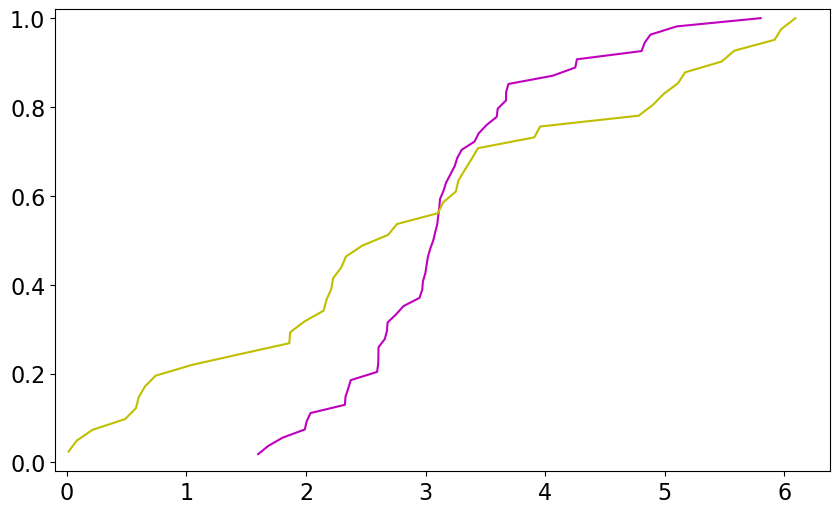

In [24]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/len(xs)
    return xs, ys

fig, ax = plt.subplots(1, 1, figsize=(10,6))
Delta_threshold = 0.006
sample_1 = df[np.abs(df['Delta']) < Delta_threshold]
sample_2 = df[np.abs(df['Delta']) > Delta_threshold]
plt.plot(*ecdf(sample_1['theta_hat']), c='m')
plt.plot(*ecdf(sample_2['theta_hat']), c='y')
ax.set_xlim(-0.1, 2*np.pi+0.1)
ax.set_ylim(-0.02, 1.02)

Text(0.5, 0, '$e$')

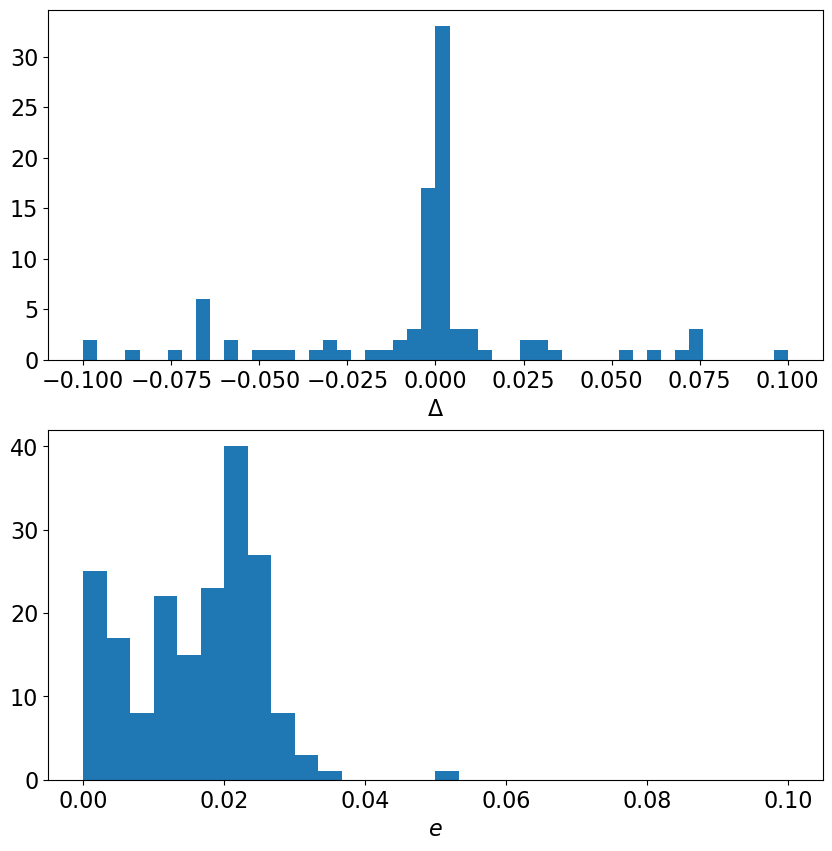

In [25]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
axs[0].hist(df['Delta'], bins=50, range=(-0.1, 0.1))
axs[0].set_xlabel('$\Delta$')
axs[1].hist(pd.concat((df['e1'],df['e2'])), bins=30, range=(0, 0.1))
axs[1].set_xlabel('$e$')

In [26]:
if sim_type == 'disk':
    fig, axs = plt.subplots(5, 1, figsize=(10,12), sharex=True, gridspec_kw={'hspace':0})
    axs[0].scatter(df['fixed_tau_a']/df['fixed_tau_e'], np.abs(df['Delta']), c=np.where(df['theta_hat_librating'], 'r', 'k'))
    axs[1].scatter(df['fixed_tau_a']/df['fixed_tau_e'], df['Zabs'], c=np.where(df['theta_hat_librating'], 'r', 'k'))
    axs[2].scatter(df['fixed_tau_a']/df['fixed_tau_e'], np.remainder(df['Delta_pomega'] + np.pi, 2*np.pi) - np.pi, c=np.where(df['theta_hat_librating'], 'r', 'k'))
    axs[3].scatter(df['fixed_tau_a']/df['fixed_tau_e'], df['e1'], c=np.where(df['theta_hat_librating'], 'r', 'k'))
    axs[3].scatter(df['fixed_tau_a']/df['fixed_tau_e'], df['e2'], c=np.where(df['theta_hat_librating'], 'r', 'k'))
    axs[4].scatter(df['fixed_tau_a']/df['fixed_tau_e'], df['theta_hat'], c=np.where(df['theta_hat_librating'], 'r', 'k'))
    # axs[-1].set_xlabel('Disk eccentricity', fontsize=14)
    axs[-1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylim(1e-4, 1e-1)
    axs[1].set_ylim(1e-4, 1e-1)
    axs[3].set_yscale('log')
    axs[0].set_ylabel('$\Delta$', fontsize=14)
    axs[1].set_ylabel('$|\mathcal{Z}|$', fontsize=14)
    axs[2].set_ylabel(r'$\varpi_2-\varpi_1$', fontsize=14)
    axs[3].set_ylabel(r'$e$', fontsize=14)
    axs[4].set_ylabel(r'$\hat{\theta}$', fontsize=14)

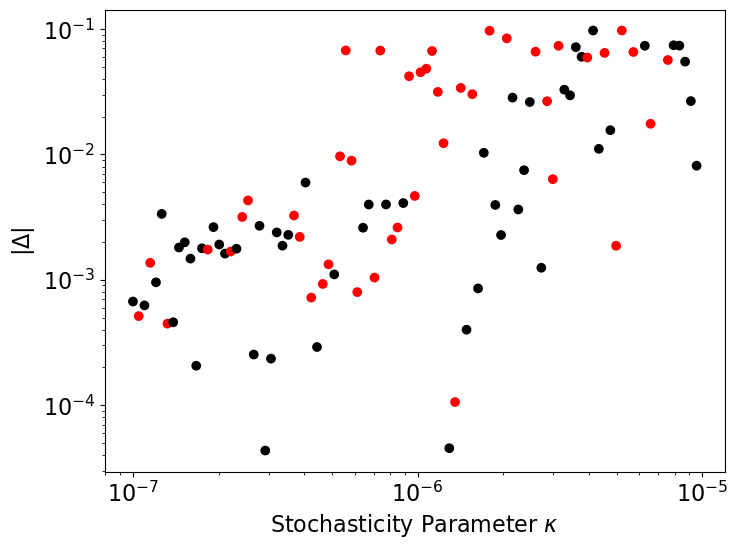

In [27]:
if sim_type == 'stoch_disk':
    plt.figure(figsize=(8,6))
    plt.scatter(df['kappa'], np.abs(df['Delta']), c=np.where(df['Delta'] > 0, 'k', 'r'))
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Stochasticity Parameter $\kappa$')
    plt.ylabel('$|\Delta|$')
    # plt.savefig('figs/stoch_disk_kappa_vs_Delta.pdf')

In [28]:
if sim_type == 'planetesimals':
    plt.scatter(df['pl_disk_mass']*332900, np.abs(df['Delta']), c=np.where(df['Delta'] > 0, 'k', 'r'))
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Disk Mass $M_\mathrm{disk}~(M_\oplus)$')
    plt.ylabel('$\Delta$')

In [29]:
with open(path / '30.pkl', 'rb') as f:
    sim = pickle.load(f)
ham = ResHam.from_capture_sim(sim)

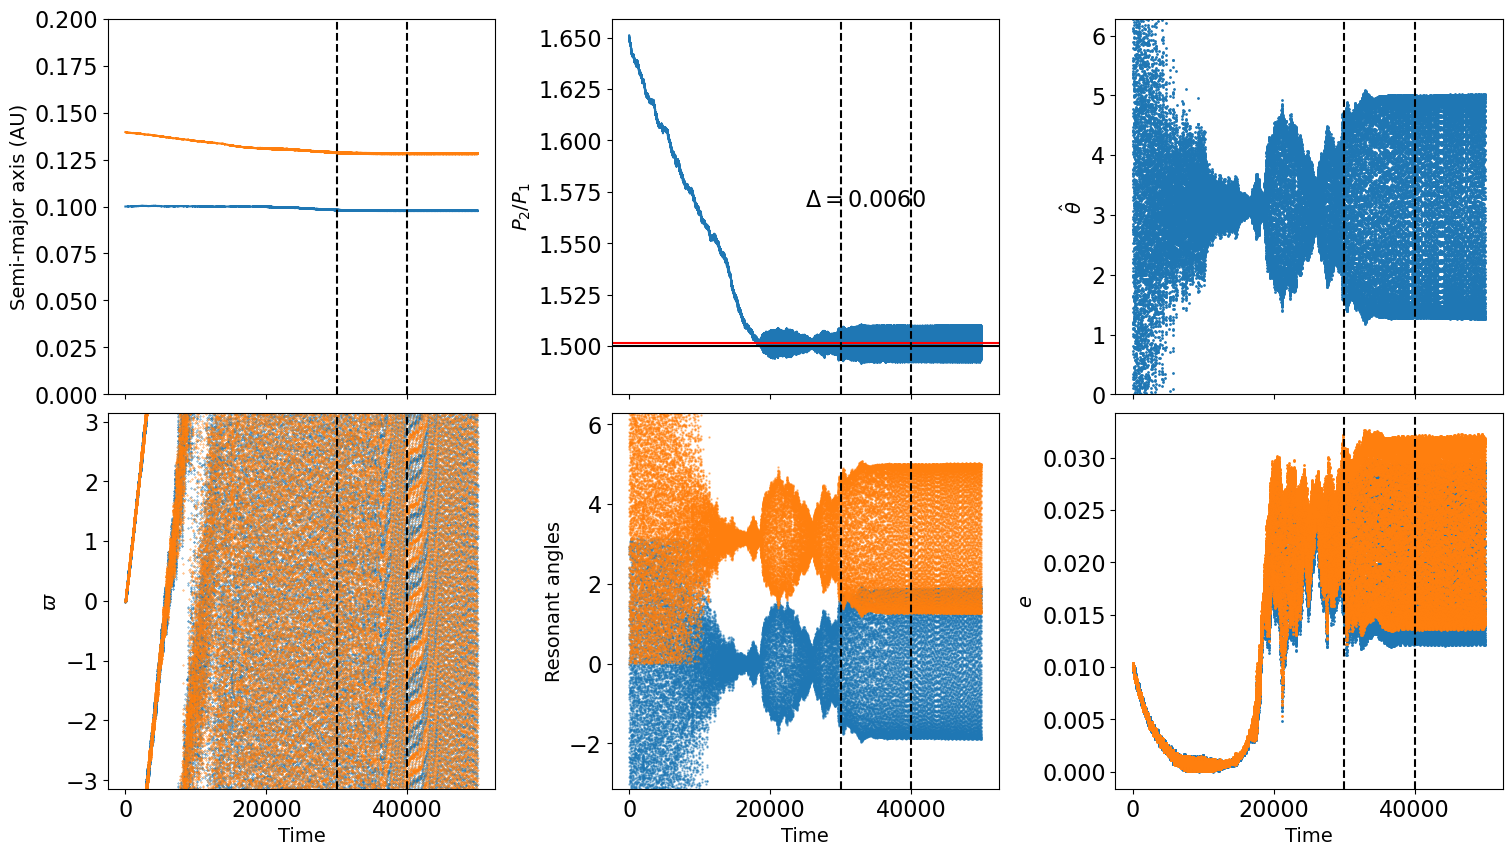

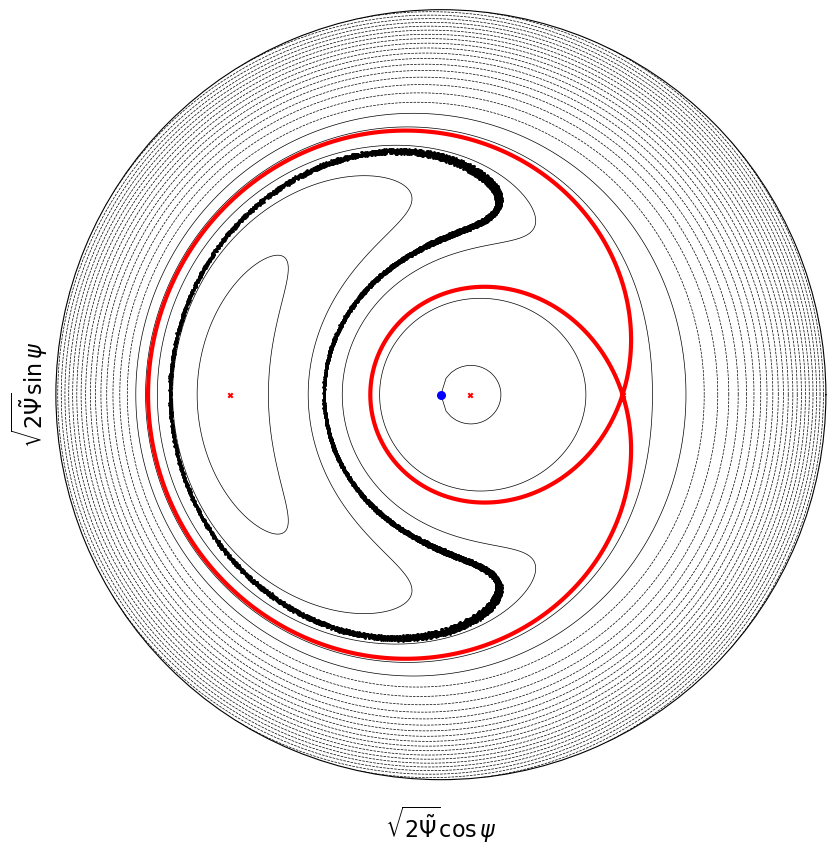

In [31]:
fig, axs = sim.plot()
# axs[0,0].set_xscale('log')
# axs[0,0].set_xlim(1e2, 5e4)
ham.phase_space_plot()

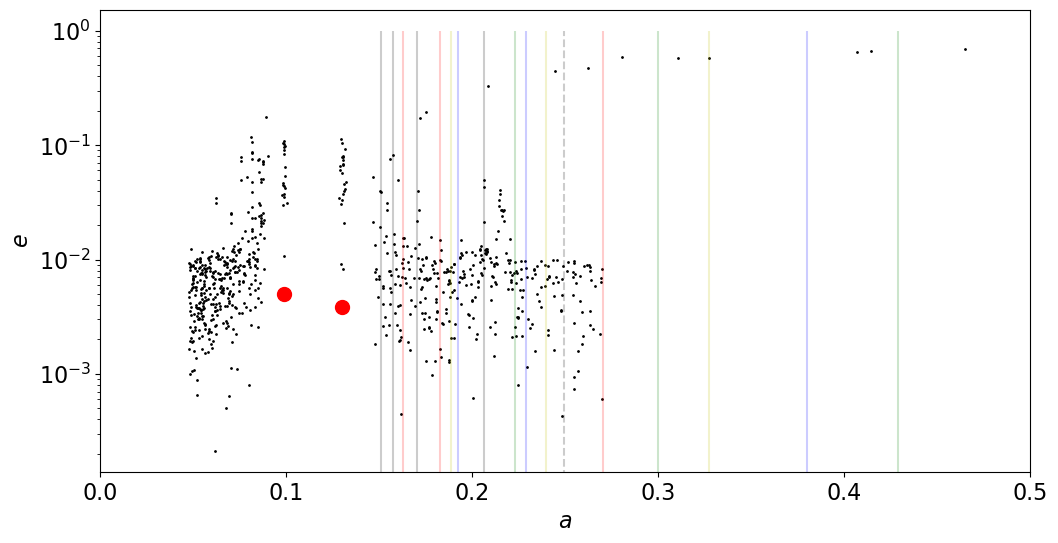

In [17]:
if sim_type == 'planetesimals':
    plt.figure(figsize=(12,6))
    plt.scatter(sim.pl_disk.orbits['a'], sim.pl_disk.orbits['e'], c='k', s=1)
    plt.scatter(sim.orbits[-1,0,0], sim.orbits[-1,0,1], c='r', s=100)
    plt.scatter(sim.orbits[-1,1,0], sim.orbits[-1,1,1], c='r', s=100)
    plt.vlines(sim.orbits[-1,1,0]*np.array([2/1, 3/2, 4/3, 5/4])**(2/3), ymin=0, ymax=1, color='k', ls='-', alpha=0.2)
    plt.vlines(sim.orbits[-1,1,0]*np.array([3/1, 5/3, 7/5])**(2/3), ymin=0, ymax=1, color='r', ls='-', alpha=0.2)
    plt.vlines(sim.orbits[-1,1,0]*np.array([4/1, 5/2, 7/4])**(2/3), ymin=0, ymax=1, color='y', ls='-', alpha=0.2)
    plt.vlines(sim.orbits[-1,1,0]*np.array([5/1, 7/3, 9/5])**(2/3), ymin=0, ymax=1, color='b', ls='-', alpha=0.2)
    plt.vlines(sim.orbits[-1,1,0]*np.array([6/1, 7/2, 9/4])**(2/3), ymin=0, ymax=1, color='g', ls='-', alpha=0.2)
    plt.vlines(sim.orbits[-1,0,0]*np.array([4/1])**(2/3), ymin=0, ymax=1, color='k', ls='--', alpha=0.2)
    # plt.ylim(0, 0.5)
    plt.yscale('log')
    plt.xlim(0, 0.5)
    plt.xlabel('$a$'); plt.ylabel('$e$')

300


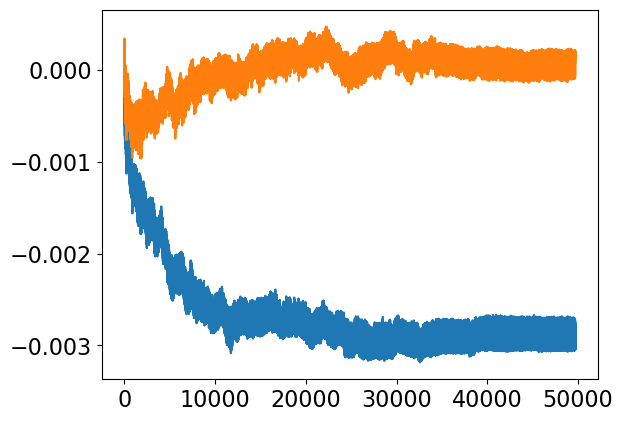

In [18]:
disk_end_idx = np.argsort(np.abs(sim.times - sim.disk_end))[0]
print(disk_end_idx)
plt.plot(sim.times[disk_end_idx:] - sim.disk_end, sim.orbits[disk_end_idx:,0,0]/sim.orbits[disk_end_idx,0,0] - 1)
plt.plot(sim.times[disk_end_idx:] - sim.disk_end, sim.orbits[disk_end_idx:,1,0]/sim.orbits[disk_end_idx,1,0] - 1)
# plt.xscale('log')

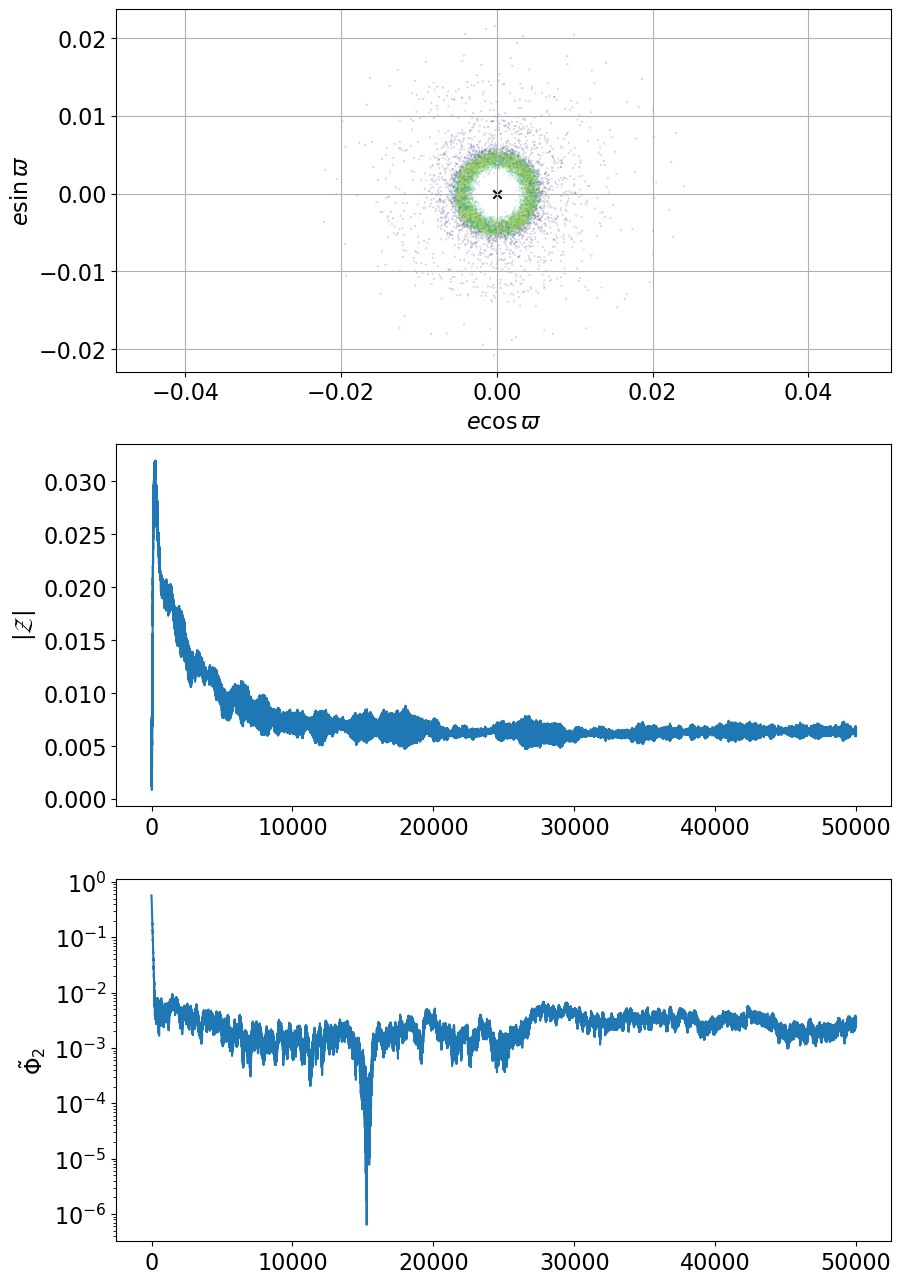

In [19]:
#plt.plot(times,e1,label="e")
fig, axs = plt.subplots(3, 1, figsize=(10,16))
axs[0].scatter(sim.get_ecc_vectors()[0][::10], sim.get_ecc_vectors()[1][::10], label="pomega", s=0.01, c=np.repeat(sim.times[::10], 2))
axs[0].scatter(0, 0, color='k', marker='x')
try:
    axs[0].scatter(sim.disk.e0, 0, color='r', marker='x')
except AttributeError:
    pass
# axs[0].scatter(-ecc_disk.B_d(sim, 1)/ecc_disk.A_d(sim, 1)*np.cos(ecc_disk.pomega), -ecc_disk.B_d(sim, 1)/ecc_disk.A_d(sim, 1)*np.sin(ecc_disk.pomega), color='r', zorder=100)
axs[0].axis('equal')
axs[0].set_xlabel(r'$e\cos\varpi$')
axs[0].set_ylabel(r'$e\sin\varpi$')
axs[0].grid()
axs[1].plot(sim.times, sim.get_abs_Z())
axs[1].set_ylabel('$|\mathcal{Z}|$')
axs[2].plot(sim.times, ham.Phi_2_tilde)
axs[2].set_ylabel(r'$\tilde{\Phi}_2$')
axs[2].set_yscale('log')
# plt.savefig(f'figs/{p}_{p-q}_{ecc_disk.e0}_test.png')

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(i):
    ax.clear()
    psi_list = np.linspace(0, 2*np.pi, 500)
    Psi_max = ham.Psi_tilde[ham.i_to_plot:].max()*2
    Psi_list = np.linspace(0, Psi_max, 500)
    Psi_list, psi_list = np.meshgrid(Psi_list, psi_list)
    values, p_eq = ham.get_H_contours(i, Psi_list, psi_list)
    p_eq = p_eq[np.isreal(p_eq)].real
    ax.contour(psi_list, np.sqrt(2*Psi_list), values, levels=50, zorder=0, colors='k', linewidths=0.5)
    i_ahead = 50
    ax.scatter(ham.psi[i:i+i_ahead], np.sqrt(2*ham.Psi_tilde[i:i+i_ahead]), s=1, c='k')
    ax.scatter(np.arctan2(0, p_eq), np.abs(p_eq), s=10, c='r', marker='x')
    if len(p_eq) == 3:
        sep, _ = ham.get_H_contours(i, p_eq[-1]**2/2, 0)
        ax.contour(psi_list, np.sqrt(2*Psi_list), values, levels=[sep], zorder=0, colors='r', linewidths=3)
    ax.grid(False)
    return ax

# ani = FuncAnimation(fig, animate, frames=range(10000, 70000, 200), interval=500)
# ani.save('animation.mp4', writer='ffmpeg', fps=20)